In this notebook I try to reproduce the result from the paper (https://arxiv.org/pdf/1506.02142.pdf) for MNIST classification. The goal is to obtain uncertainty estimation based on dropouts. 

In [2]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from PIL import Image

In [3]:
#MNIST classification FC network adopted from somewhere in the Internet and slightly modified
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.relu2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')



/home/crunchy/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw




Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/home/crunchy/extralibs/vision/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch [1/5], Step [100/600], Loss: 0.6451
Epoch [1/5], Step [200/600], Loss: 0.4119
Epoch [1/5], Step [300/600], Loss: 0.4003
Epoch [1/5], Step [400/600], Loss: 0.4039
Epoch [1/5], Step [500/600], Loss: 0.3002
Epoch [1/5], Step [600/600], Loss: 0.1970
Epoch [2/5], Step [100/600], Loss: 0.2794
Epoch [2/5], Step [200/600], Loss: 0.1654
Epoch [2/5], Step [300/600], Loss: 0.1257
Epoch [2/5], Step [400/600], Loss: 0.1806
Epoch [2/5], Step [500/600], Loss: 0.1679
Epoch [2/5], Step [600/600], Loss: 0.0877
Epoch [3/5], Step [100/600], Loss: 0.0554
Epoch [3/5], Step [200/600], Loss: 0.0886
Epoch [3/5], Step [300/600], Loss: 0.1266
Epoch [3/5], Step [400/600], Loss: 0.0632
Epoch [3/5], Step [500/600], Loss: 0.1311
Epoch [3/5], Step [600/600], Loss: 0.2117
Epoch [4/5], Step [100/600], Loss: 0.1710
Epoch [4/5], Step [200/600], Loss: 0.0720
Epoch [4/5], Step [300/600], Loss: 0.0617
Epoch [4/5], Step [400/600], Loss: 0.0454
Epoch [4/5], Step [500/600], Loss: 0.1338
Epoch [4/5], Step [600/600], Loss:

In [4]:
index = 5
for test_images, test_labels in test_loader:  
    sample_image = test_images[index]    
    sample_label = test_labels[index]
    break

In [5]:
#making set of rotated images
mod_images = []
for i in range(10):
    mod_image = torch.Tensor(np.array(Image.fromarray(sample_image.view(28,28).detach().numpy()).rotate(-i*10))).view(1,28,28)
    mod_images.append(mod_image)

tensor([[-4.7094,  8.5481, -1.4367, -3.4374, -1.5006, -4.4737, -6.2520,  2.4778,
         -1.5631, -2.7179]], grad_fn=<AddmmBackward>)


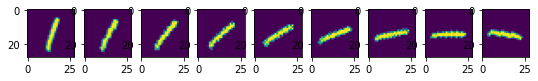

In [13]:
print(model(mod_images[1].reshape(-1,784)))
fig = plt.figure(figsize=(9,1))
for i in range(9):
    fig.add_subplot(int('19{}'.format(i+1)))
    plt.imshow(mod_images[i].view(28,28))

In [17]:
#we need a portion of binary vectors to get a distribution of prediction
from scipy.stats import bernoulli
def bernoulli_diagonal(mat):
    p=0.5
    r = torch.Tensor(bernoulli.rvs(p, size=mat.shape[1]))
    ind = np.diag_indices(mat.shape[1])
    diag_mat = torch.zeros((mat.shape[1], mat.shape[1]))
    diag_mat[ind[0], ind[1]] = r
    return torch.Tensor(diag_mat)

In [18]:
#actual distribution generation
def distr_gen(model, sample_image, T):
    distr = np.zeros((T,10))
    for t in range(T):
        model_copy = copy.deepcopy(model)
    
        data = model_copy.fc1.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc1.weight = nn.Parameter(dropout_data)
    
        data = model_copy.fc2.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc2.weight = nn.Parameter(dropout_data)
    
        data = model_copy.fc3.weight.data
        diag = bernoulli_diagonal(data)
        dropout_data = torch.matmul(data,diag)
        model_copy.fc3.weight = nn.Parameter(dropout_data)
    
        distr[t] = model_copy(sample_image.reshape(-1,784)).detach().numpy()[0]
    return distr

In [19]:
#here I try to examine the impact of different activation functions
tau = 10
distr = distr_gen(model, sample_image, 100)
mean = np.mean(distr,axis=0)
covariance = 1/tau*np.identity(len(mean))
covariance += np.mean(np.array([np.outer(x,x) for x in distr]),axis=0) - np.outer(mean,mean)
std = np.sqrt(covariance.diagonal())

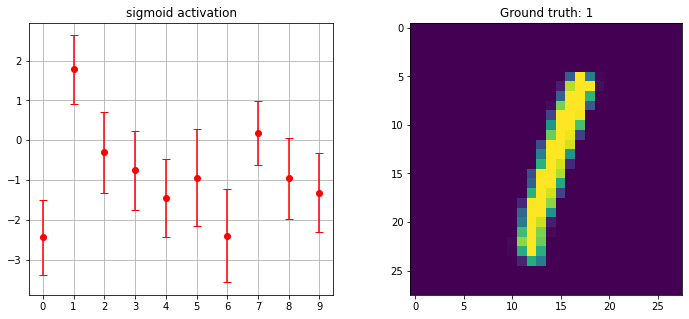

In [20]:
activation = 'sigmoid'
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title(activation + ' activation')
plt.errorbar(list(range(10)),mean,yerr=std, fmt='ro', capsize=4)
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.grid('True')

fig.add_subplot(122)
plt.title('Ground truth: {}'.format(sample_label))
plt.imshow(sample_image.view(28,28))
#plt.savefig(activation + ' activation, label {}.png'.format(label))
plt.show()

In [22]:
#now I am trying to reproduce the result from the paper
#how does the rotation of an image with "1" impacts the predictions and uncertainty
#I will track the predictions for "1", "5" and "7"
distrs = []
for i in range(10):
    distrs.append(distr_gen(model,mod_images[i],100))

In [31]:
means = np.zeros((10,10))
stds = np.zeros((10,10))
for i in range(10):
    mean = np.mean(distrs[i],axis=0)
    means[i] = mean
    covariance = 1/tau*np.identity(len(mean))
    covariance += np.mean(np.array([np.outer(x,x) for x in distrs[i]]),axis=0) - np.outer(mean,mean)
    std = np.sqrt(covariance.diagonal())
    stds[i] = std    

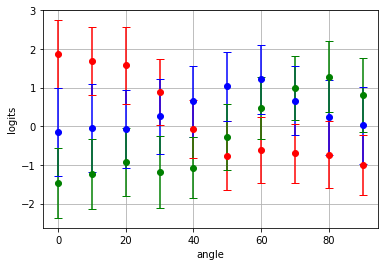

actual predictions:  [1 1 1 1 2 2 2 4 4 4]


In [41]:
X = np.arange(10)*10
plt.errorbar(X, means[:,1], yerr=stds[:,1], fmt='ro',capsize=4)
plt.errorbar(X, means[:,2], yerr=stds[:,2], fmt='bo',capsize=4)
plt.errorbar(X, means[:,4], yerr=stds[:,4], fmt='go',capsize=4)
plt.xlabel('angle')
plt.ylabel('logits')
plt.grid(True)
plt.show()
print('actual predictions: ',np.argmax(means, axis=1))

As wee see from the plot, prediction distributions do overlap as the image rotates. We may develop an uncertainty criterion from there: if overlapping is not significant than the prediction is okay. From the figure we can see that "certain" predictions are only for slightly rotated image while the others are non-sense. 